In [4]:
import hydra
from glob import  glob
from proteoscope.datamodule import ProteoscopeDataModule
from proteoscope.proteoscopemodule import ProteoscopeLightningModule
import numpy as np
from omegaconf import OmegaConf


# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-05-26/20-52-13"
# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-07-19/18-28-20"
BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-07-19/16-42-34"
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1]
    print('   Using ', chkpt)


    pdm = ProteoscopeDataModule(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        sequences_path=config.data.sequences_path,
        batch_size=config.trainer.batch_size,
        num_workers=config.trainer.num_workers,
    )
    pdm.setup()

    plm = ProteoscopeLightningModule.load_from_checkpoint(
        chkpt,
        module_config=config.module,
        unet_number=1,
    )

    plm.model.eval()
    plm.model.cuda()
    plm.cytoself_model.cuda()

/tmp/ipykernel_9006/1542303288.py:14: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs-proteoscope/2023-07-19/16-42-34/checkpoints/last.ckpt


/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [16]:
pdm.val_images_dataset.labels = pdm.val_images_dataset.labels.drop_duplicates(subset='ensg')
dl = pdm.val_dataloader(novel_proteins=False, shuffle=True)

In [5]:
dl = pdm.val_dataloader(novel_proteins=True, shuffle=True)
batch = next(iter(dl))

In [17]:
from tqdm import tqdm

outputs = []
locs = []

cond_images_base = batch['image'][0, 1, :, :].unsqueeze(dim=0).unsqueeze(dim=0).cuda()
for batch in tqdm(dl):
    seq_embeds = batch['sequence_embed'].cuda()
    seq_mask = batch['sequence_mask'].cuda()
    images = batch['image'][:, 0, :, :].unsqueeze(dim=1).cuda()
    # cond_images = batch['image'][:, 1, :, :].unsqueeze(dim=1).cuda()
    cond_images = cond_images_base.repeat(batch['image'].shape[0], 1, 1, 1)
    output_encoded_images = plm.model.sample(text_embeds=seq_embeds, text_masks=seq_mask, cond_images=cond_images, cond_scale = 3.)
    vq_outputs = plm.cytoself_model.vq_layers[1](output_encoded_images)
    output_vqvae2 = vq_outputs[1].detach().cpu().numpy()
    locs.append(np.array(batch['localization']))
    outputs.append(output_vqvae2)
locs = np.concatenate(locs, axis=0)
outputs = np.concatenate(outputs, axis=0)

  0%|          | 0/17 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

  6%|▌         | 1/17 [00:15<04:15, 15.97s/it]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 2/17 [00:25<02:59, 11.99s/it]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 3/17 [00:34<02:29, 10.67s/it]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▎       | 4/17 [00:43<02:10, 10.07s/it]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:52<01:56,  9.74s/it]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 35%|███▌      | 6/17 [01:01<01:44,  9.54s/it]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 41%|████      | 7/17 [01:10<01:34,  9.41s/it]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 47%|████▋     | 8/17 [01:20<01:23,  9.32s/it]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 53%|█████▎    | 9/17 [01:29<01:15,  9.38s/it]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 59%|█████▉    | 10/17 [01:38<01:05,  9.40s/it]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 65%|██████▍   | 11/17 [01:47<00:55,  9.28s/it]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 71%|███████   | 12/17 [01:56<00:45,  9.19s/it]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 76%|███████▋  | 13/17 [02:05<00:36,  9.13s/it]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 82%|████████▏ | 14/17 [02:14<00:27,  9.10s/it]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 88%|████████▊ | 15/17 [02:24<00:18,  9.09s/it]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

 94%|█████████▍| 16/17 [02:33<00:09,  9.08s/it]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 17/17 [02:42<00:00,  9.54s/it]


In [4]:
# locs = np.concatenate(locs, axis=0)
# outputs = np.concatenate(outputs, axis=0)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 locs = np.concatenate(locs, axis=0)                                                          │
│   2 outputs = np.concatenate(outputs, axis=0)                                                    │
│   3                                                                                              │
│ in concatenate:180                                                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: zero-dimensional arrays cannot be concatenated

In [4]:
plm.cytoself_model.emb_shapes[0][1:]

(25, 25)

In [39]:
from torchvision.transforms import InterpolationMode
from torchvision.transforms.functional import resize

In [40]:
shape = [25, 25]
output_images_resized = resize(output_images, shape, interpolation=InterpolationMode.NEAREST)

In [31]:
import torch

In [47]:
vqvec1 = plm.cytoself_model(batch['image'].cuda(), 'vqvec1')

In [48]:
vqvec1.shape

torch.Size([64, 64, 25, 25])

In [65]:
decoded_images = plm.cytoself_model.decoders[0](torch.cat([output_images_resized, vqvec1], 1))


In [66]:
decoded_images.shape

torch.Size([64, 2, 100, 100])

In [67]:
decoded_images = decoded_images.detach().cpu().numpy()

In [54]:
import matplotlib.pyplot as plt

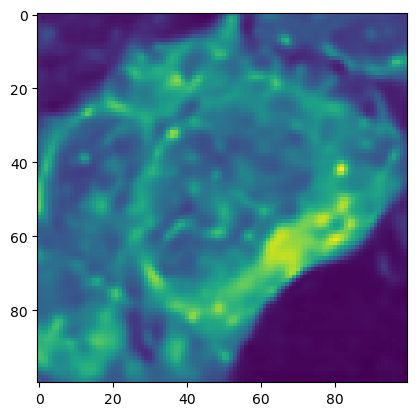

In [72]:
plt.imshow(decoded_images[1, 0])

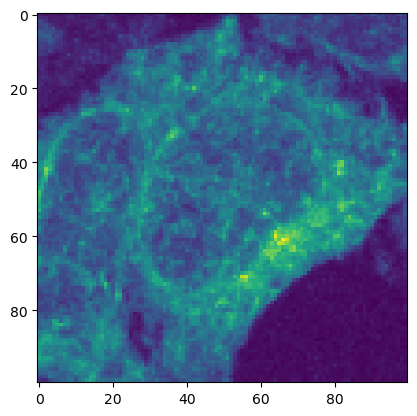

In [73]:
plt.imshow(input_images[1, 0])

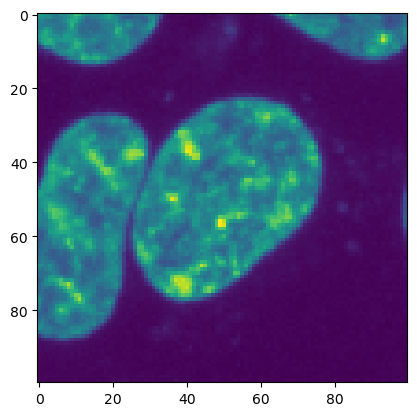

In [71]:
plt.imshow(cond_images[1, 0])

In [58]:
output_images = output_images.detach().cpu().numpy()
input_images = images.detach().cpu().numpy()
cond_images = cond_images.detach().cpu().numpy()

In [7]:
output_images.shape

torch.Size([64, 64, 4, 4])

In [15]:
locs

array(['', '', '', ..., '', '', ''], dtype='<U1')

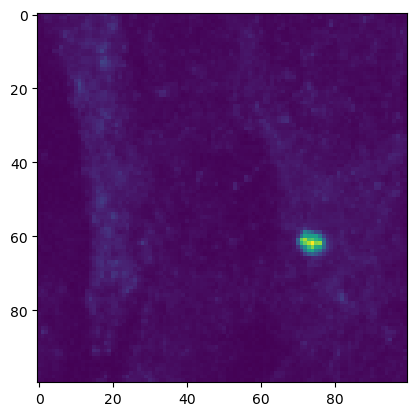

In [89]:
import matplotlib.pyplot as plt
plt.imshow(batch['image'][2, 0])

In [90]:
seq_embeds = batch['sequence_embed'].cuda()
seq_mask = batch['sequence_mask'].cuda()
images = batch['image'][:, 0, :, :].unsqueeze(dim=1).cuda()
cond_images = batch['image'][:, 1, :, :].unsqueeze(dim=1).cuda()
plm.model.cuda()

output_images = plm.model.sample(text_embeds=seq_embeds, text_masks=seq_mask, cond_images=cond_images, cond_scale = 3.)
output_images = output_images.detach().cpu().numpy()
input_images = images.detach().cpu().numpy()
cond_images = cond_images.detach().cpu().numpy()

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

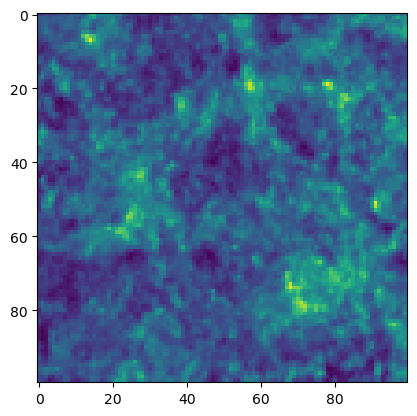

In [91]:
plt.imshow(output_images[2, 0])

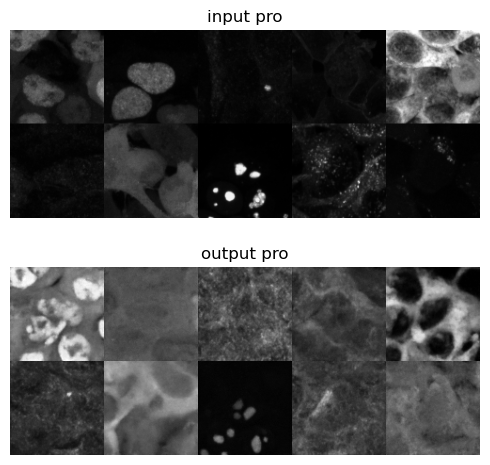

In [92]:
data_ch = ['pro']
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(input_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    t1 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(output_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    ax[0, ii].imshow(t0, cmap='gray')
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray')
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)
fig.tight_layout()
fig.show()
# fig.savefig(join(trainer.savepath_dict['visualization'], 'reconstructed_images.png'), dpi=300)

In [93]:
def merge_images(img_A, img_B):
    rgb = np.tile(img_A, (3, 1, 1)).transpose(1, 2, 0)
    rgb[:, :, 1] = img_B
    return rgb

In [94]:
id = 4

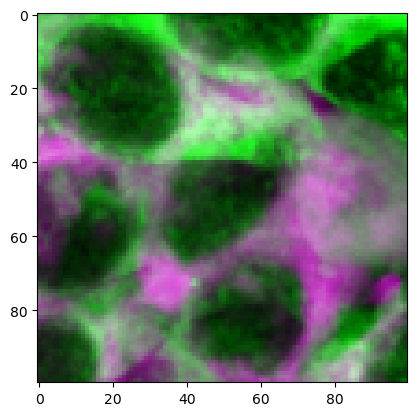

In [95]:
plt.imshow(merge_images(output_images[id], input_images[id]))

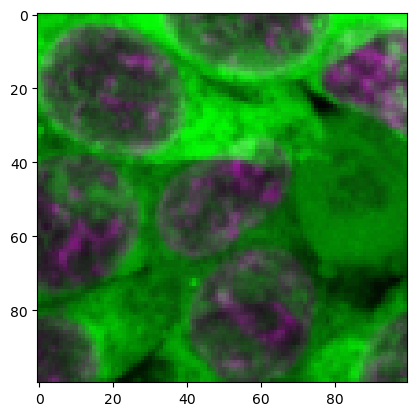

In [96]:
plt.imshow(merge_images(cond_images[id]*1, input_images[id]))

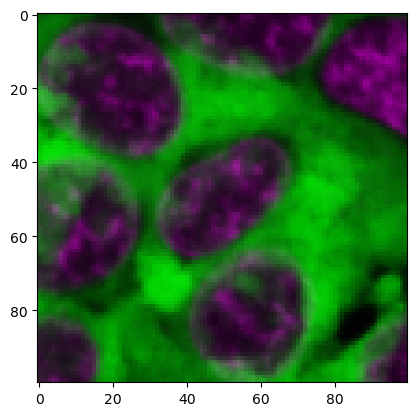

In [97]:
plt.imshow(merge_images(cond_images[id]*1, output_images[id]))

# Cytoself

In [9]:
import zarr
import numpy as np
from os.path import join

datapath = "/home/ec2-user/cytoself-data/"
zarr_path = join(datapath, "good_embeddings.zarr")

embeddings = np.asarray(zarr.open(zarr_path, mode='r'))
localizations = np.load(join(datapath, "good_localizations.npy"))

In [10]:
from joblib import load

reducer = load(join(datapath,'good_umap_model.joblib'))

In [11]:
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))
localizations[localizations == ''] = 'other'

In [12]:
import seaborn as sns

label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

<AxesSubplot:>

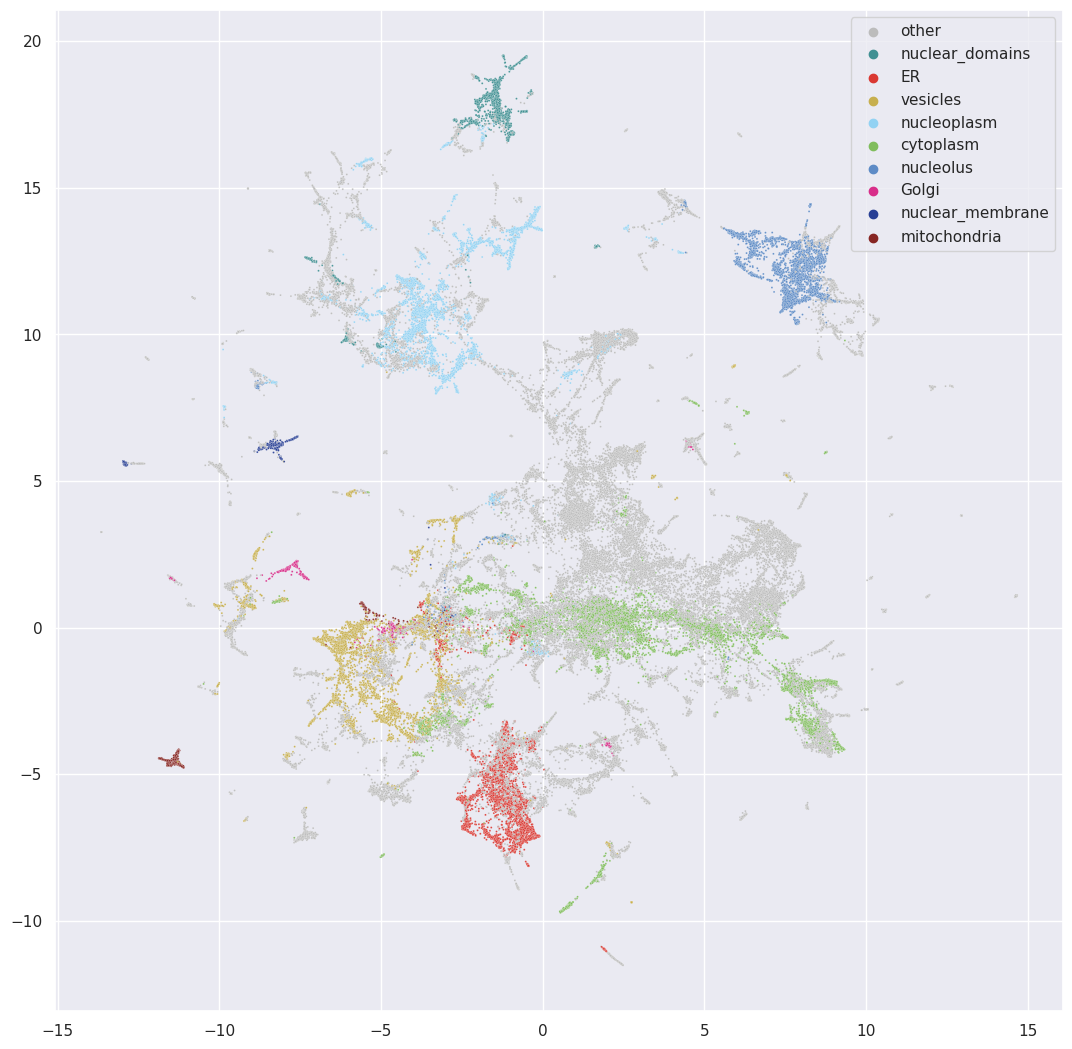

In [13]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)

In [18]:
reduced_outputs = reducer.transform(outputs.reshape(outputs.shape[0], -1))
reduced_locs = locs
reduced_locs[reduced_locs == ''] = 'other'

In [22]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_outputs[:, 0], y=reduced_outputs[:, 1], hue=reduced_locs, s=40, alpha=0.9, palette=label_colors)

<AxesSubplot:>

<AxesSubplot:>

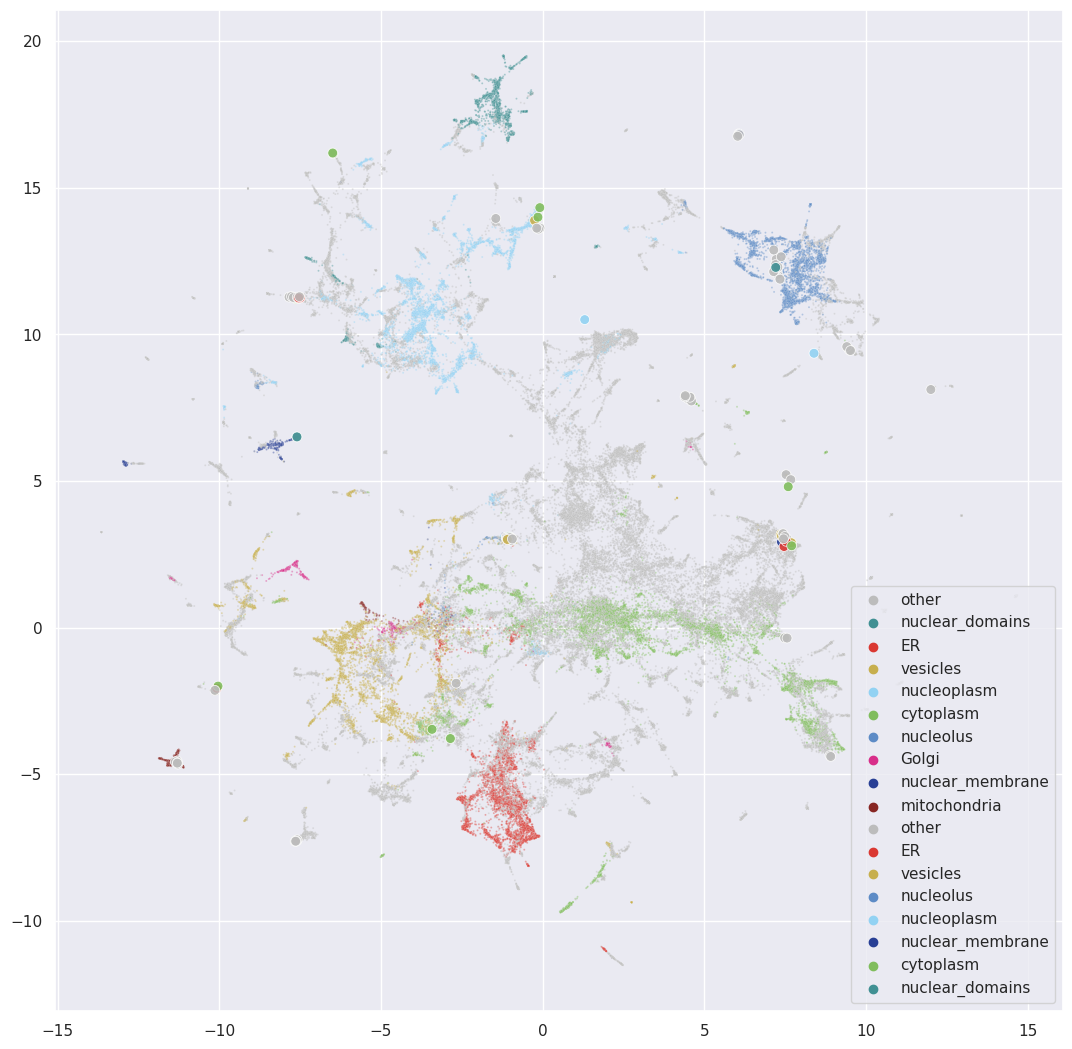

In [15]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_outputs[:, 0], y=reduced_outputs[:, 1], hue=reduced_locs, s=50, alpha=0.9, palette=label_colors)